# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
import keras.backend as K
from skimage import exposure
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from glob import glob
import pickle

In [2]:
print('GPU avalible: ' + str(len(tf.config.get_visible_devices('GPU')) > 0))

GPU avalible: True


In [3]:
SEED = 33
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data preparation.

In [4]:
imgs = glob(f'../*/*/*/frame_*_endo.png')
masks = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')

assert len(imgs) == len(masks)

print(f'Number of samples: {str(len(masks))}')

Number of samples: 8080


In [5]:
HEIGHT, WIDTH = 128, 256
N = len(masks)

In [6]:
X, y = [], []

for img, mask in zip(imgs, masks):
    img = cv2.imread(img)
    img = img[10:-10, 10:-10,:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (WIDTH, HEIGHT))
    img = img / 255
    X.append(img)

    mask = cv2.imread(mask)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)

    y.append(mask)

X = np.array(X)
y = np.array(y)

assert X.shape[0:-1] == y.shape[0:-1]

X.shape, y.shape

((8080, 128, 256, 3), (8080, 128, 256, 1))

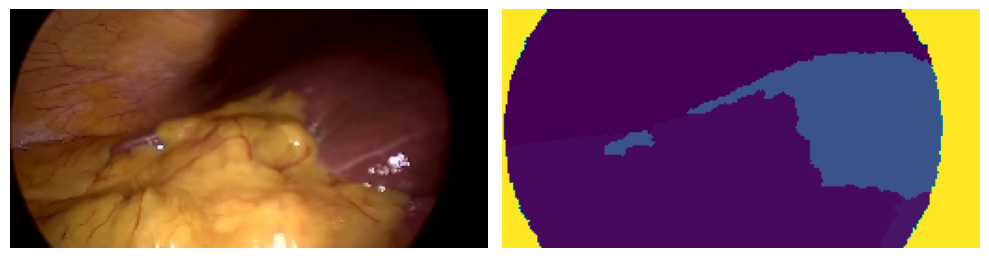

In [7]:
idx = random.randint(0, len(X)-1)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(y[idx])
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]

y_encoded = np.zeros((N, HEIGHT, WIDTH, 1), dtype=np.uint8)

for i, label in enumerate(labels):
    y_encoded[np.all(label == y, axis=-1)] = i + 1
 
y = tf.keras.utils.to_categorical(y_encoded, num_classes=13)

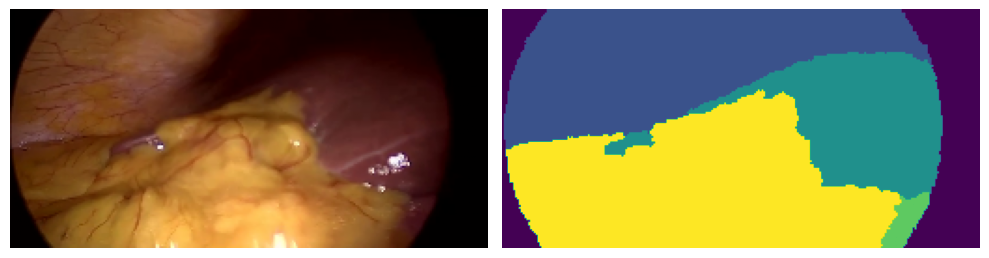

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[idx])
plt.axis("off")
plt.subplot(122)
plt.imshow(tf.argmax(y[idx], axis=-1))
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
unique = np.unique(y_encoded, return_counts=True)
assert np.sum(unique[1]) == HEIGHT * WIDTH * N
unique

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8),
 array([65074092, 59468968, 59308915,  4954278, 38911494,  6743536,
         6236880,  1135084,   104210,  3667020, 17977166,    26857,
         1156940], dtype=int64))

In [18]:
weights = unique[1] / np.sum(unique[1])
assert np.sum(weights) == 1

np.set_printoptions(precision=8, suppress=False)
print('\tWEIGHTS:\n')
print(weights)
print('\n\t1 / (WEIGHTS**2):\n')
print(1 / (weights ** 2))
print('\n\t1 - WEIGHTS:\n')
print(1 - weights)
np.set_printoptions(precision=4, suppress=True)
print('\n\tWEIGHTS %:\n')
print(np.sort(weights * 100))

	WEIGHTS:

[2.45780159e-01 2.24610010e-01 2.24005501e-01 1.87119512e-02
 1.46965911e-01 2.54698498e-02 2.35562466e-02 4.28713053e-03
 3.93593665e-04 1.38500705e-02 6.78984614e-02 1.01436955e-04
 4.36967906e-03]

	1 / (WEIGHTS**2):

[1.65541299e+01 1.98217406e+01 1.99288681e+01 2.85602396e+03
 4.62984850e+01 1.54151314e+03 1.80213705e+03 5.44084793e+04
 6.45511226e+06 5.21309974e+03 2.16910280e+02 9.71868695e+07
 5.23722121e+04]

	1 - WEIGHTS:

[0.75421984 0.77538999 0.7759945  0.98128805 0.85303409 0.97453015
 0.97644375 0.99571287 0.99960641 0.98614993 0.93210154 0.99989856
 0.99563032]

	WEIGHTS %:

[ 0.0101  0.0394  0.4287  0.437   1.385   1.8712  2.3556  2.547   6.7898
 14.6966 22.4006 22.461  24.578 ]


 --- 
 TFG - Alejandro García Mota